# Homework 3 - Master's Degrees from all over!
---


## IMPORTING LIBRARIES 

In [ ]:
# TO ADD/MODIFY FOR RQ1

In [ ]:
import pandas as pd
import numpy as np
import regex as re
import heapq
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from importlib import reload  # To reload the imported modules

# Importing our custom modules for currency conversion
from modules import currency

# Importing our custom modules for ceating the index
from modules import engine_v1, engine_v2
reload(engine_v1)
reload(engine_v2)

# Setting the NLTK environment to work with English language
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
stops = set(stopwords.words('english'))

porterStemmer = PorterStemmer()


# To display all columns and not only a sample
pd.set_option('display.max_columns', None)

dataset_folder = "data/TSVs/"

NUM_COURSES = 100

---
## [1] Data collection

### [1.1] Get the list of master's degree courses

### [1.2] Crawl master's degree pages

### [1.3] Parse downloaded pages

---
## [2] Search Engine

### [2.0] Preprocessing the text

We use the nltk library to preprocess the dataset before using it. 

First of all we take a look at the dataset and see how it looks like. In particular we print all the unique values for the columns `isitFullTime`, `startDate`, `duration`, `administration` because they must be categorical variables.

Mayvbe check concordancy between `isItFullTime` and `duration`

The column `description`  will be preprocessed with the following operations:
  1. Removing punctuation 
  2. Tokenization
  2. Removing stopwords
  3. Stemming
  4. Lowering the case of all the words

In [ ]:
# First of all we import all the files and we create a single big dataframe to understand the data
df = pd.DataFrame()

col_names = ['courseName','universityName','facultyName', 'isItFullTime','description','startDate','fees','modality','duration','city','country','administration','url']

for i in range(1, NUM_COURSES + 1):
  # Read the i-th course_i.tsv file
  df_course = pd.read_csv(dataset_folder + "course_" + str(i) + ".tsv", sep='\t', names = col_names, header=None)
  # Add the index 
  df_course['index'] = i
  df_course.set_index('index', inplace=True) 
  # Append the dataframe to the full dataframe 
  df = pd.concat([df, df_course])

# so that we can always use it when given the output of a query
df_original = df.copy()

#Print the dataframe
df

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
index,,,,,,,,,,,,,
1,3D Design for Virtual Environments - MSc,Glasgow Caledonian University,School of Engineering and Built Environment,Full time,3D visualisation and animation play a role in ...,September,Please see the university website for further ...,MSc,1 year full-time,Glasgow,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,"Accounting, Accountability & Financial Managem...",King’s College London,King’s Business School,Full time,"Our Accounting, Accountability & Financial Man...",September,Please see the university website for further ...,MSc,1 year FT,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Accounting and Finance (MSc),University of Bath,School of Management,Full time,Develop in-depth knowledge of accounting and f...,September,Please see the university website for further ...,MSc,1 year full-time,Bath,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Accounting and Finance - MSc,University of Leeds,Leeds University Business School,Full time,Businesses and governments rely on sound finan...,September,"UK: £18,000 (Total)International: £34,750 (Total)",MSc,1 year full time,Leeds,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
5,"Accounting, Financial Management and Digital B...",University of Reading,Henley Business School,Full time,Embark on a professional accounting career wit...,September,Please see the university website for further ...,MSc,1 year full time,Reading,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Biomedical Science MSc,Coventry University,Faculty of Health and Life Sciences,Full time,"As key contributors to modern healthcare, incl...",September,UK Fees: 2022/23 fees TBC*;2021/22 fees - 1040...,MSc,"1 year full time, 2 years part time, 20 months...",Coventry,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
97,Biomedical Sciences,Maastricht University,Faculty of Health Medicine and Life Sciences,Full time,From gene to health. Explore the clinical and ...,September,Academic year 2024/2025The statutory fee for t...,MSc,2 Years,Maastricht,Netherlands,On Campus,https://www.findamasters.com/masters-degrees/c...
98,Biomedical Sciences - Cancer Biology MSc,University of Westminster,Biological and Biomedical Sciences,Full time,Our Biomedical Sciences (Cancer Biology) MSc h...,September,Please see the university website for further ...,MSc,Full-time: 1 year; Part-time: 2 years,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


In [ ]:
# Now we finally focus on preprocessing the 'description' column

# We subtitute the NaN values with an empty string
df.fillna('', inplace = True)

# We lower the case of all the words
df['prep_description'] = df['description'].apply(lambda text: text.lower())

# REMOVE PUNCTUATION using regex
# # n particular we substitute all the punctuation with an empty string, avoiding to remove the dashes inside the words
# The regex has tre filters: 
# - the first eliminates everything that is not a letter, a number, a space or a dash
# - the second and the third eliminate the dashes that are not between two letters
# Some examples: eye- --> eye, -eye --> eye, eye-catching --> eye-catching

def remove_punctuation(text):
    # Sometime raises TypeError: expected string or buffer
    # So we must check that it's a string before removing punctuation
    if isinstance(text, str):
        return re.sub(r"[^a-zA-Z0-9\s\-]|((?<=[a-zA-Z\W])\-(?=[^a-zA-Z]))|((?<=[^a-zA-Z])\-(?=[a-zA-Z\W]))", "", text)
    else:
        return text

# Apply the function to 'description' column
df['prep_description'] = df['prep_description'].apply(remove_punctuation)

# TOKENIZATION using the word_tokenize() function of NLTK
df['prep_description'] = df['prep_description'].apply(lambda text: nltk.word_tokenize(text))


# REMOVING STOPWORDS using the stopwords list of NLTK
df['prep_description'] = df['prep_description'].apply(lambda words: [x for x in words if x not in stops] )


# STEMMING using the PorterStemmer of NLTK
porterStemmer = PorterStemmer()
df['prep_description'] = df['prep_description'].apply(lambda words: [porterStemmer.stem(x) for x in words])

In [ ]:
# First of all we check if every record has only one currency symbol inside
# Instead of using re we use regex, because supports unicode characters
# We use the unicode character class \p{Sc} to match any currency symbol
print("Max number of currency symbols in a record: ", df['fees'].apply(lambda x: len(list(set(re.findall(r"\p{Sc}", x)))) if isinstance(x, str) else None).max())
# The result is 1, so we can assume that every record has only one currency symbol

# Since we have only one currency symbol then we can store it in a series
currency_code = pd.Series()

def extract_currency(text):
  lst_currency = list(set(re.findall(r"\p{Sc}", str(text))))
  return lst_currency[0] if len(lst_currency) > 0 else None
  
currency_code = df['fees'].apply(extract_currency)
# Setting nan values to None
currency_code[currency_code.isna()] = None
print("List of all currencies: ", currency_code.unique())

# Then we look for numbers in the 'fees' column. Again, we use regexp to match
# numbers because, between digits, there can be symbols like ' or , or .
# With this regexp we are not able to match numbers only with at least than 3 digits
# We write a function to do that
def find_fees(text: str) -> float:
  """ 
  This function returns the maximum number found in the text passed as input
  Args:
    text: the text to search in
  Return:
      the maximum number found in the text or empty string if no number is found
  """
  global currency_code
  
  pattern = r'(?:€|\$|£)\s*\d+(?:[.,]\d+)?|\d+(?:[.,]\d+)?\s*(?:€|\$|£)'
  results = re.findall(pattern, str(text))
  if len(results) > 0:
    # Remove the currency symbol from the matched strings
    results = [re.sub(r"\p{Sc}", "", x) for x in results]
    # Remove punctuation from the matched strings and then convert them to float
    results = [float(re.sub(r"[\'\.\,\s]", "", x)) for x in results]
    return max(results)
  else:
    return ''

fees = pd.Series(data = df['fees'].apply(find_fees), index = df.index, name='fees', dtype='float64')

# Finally we create a new column 'feesEUR' that contains the fees converted in EUR
# We use our custom python modue 'currency' to do that
df['feesEUR'] = fees
df['feesEUR'] = df.apply(lambda x: currency.convert_to_EUR(x['feesEUR'], currency_code[x.name]) if x['feesEUR'] != '' else '', axis = 1)

Max number of currency symbols in a record:  1
List of all currencies:  [None '£' '€' '$']


### [2.1] Conjunctive query

#### [2.1.1] Create your index!

Most of the function that we implemented in this section are in the module `engine_v1`. Here we report a brief description. Read the comments in the `engine_v1.py` module further details.

> The module `engine_v1` has the following methods: 
> * `create_vocabulary(df: pd.DataFrame) -> dict`   
>
>   (Creates the vocabulary. **This function must be called to initializate the Search Engine**. It saves two files: `vocabulary.json` and `vocabulary_inverted.json`. The first associates a word with its integer index, while the second does the opposite)
>
> * `get_vocabulary() -> dict`
>
>   (Retrives the vocabulary (word -> term_id) from the saved file `vocabulary.json`)
>
> * `get_vocabulary_inverted() -> dict`
>
>   (Retrives the inverted vocabulary (term_id -> word) from the saved file `vocabulary_inverted.json`)
>
> * `get_term_id(word: str) -> int:`
>
>   (From a word get the corresponding term_id)
>
> * `get_word_from_id(term_id: int) -> str:`
>
>   (From a term_id get the corresponding word)
>
> * `create_inverted_index() -> dict:`
>
>   (Creates the inverted index and saves it in the file `inverted_index.json`)
>
> * `get_inverted_index() -> dict:`
>
>   (Retrives the inverted index from the file `inverted_index.json`)
>
> * `preprocess(text: str) -> list:`
>
>   (Preprocesses a string, in our case it's used to preprocess the query)
>
> * `search(query: str) -> pd.DataFrame:`
>
>   (Given a query it outputs the documents that contains all the words in the preprocessed query)
> 

The first time that we call the Search Engine (v1) we pass the entire dataframe to it. The dataframe must have a column named `prep_description`, that is the preprocessed version of the coumn `description`.

So we create the vocabulary that contains a dictionary mapping each word (in the description field) to an integer `term_id` (this will initializate the Search Engine).

In [ ]:
# Create vocabulary
vocabulary = engine_v1.create_vocabulary(df)

Now we focus on creating the inverted index. 

We create a new dictionary where the index is the `term_id` and as values has the indexes of the courses that cointain that word.

This process is done using the function `create_inverted_index()` in our module `engine_v1`.

In [ ]:
# Create inverted index
inverted_index = engine_v1.create_inverted_index()

#### [2.1.2] Execute the query

In [ ]:
## Uncomment the following two lines for manually inputting the query
# print("Input the query: ")
# query = input()

# An example of query
query = "advanced knowledge"

df_result = engine_v1.search(query)

# Showing, at most, the first 10 results of the query
df_result[['courseName','universityName','description','url']][:10]

,courseName,universityName,description,url
index,,,,
4,Accounting and Finance - MSc,University of Leeds,Businesses and governments rely on sound finan...,https://www.findamasters.com/masters-degrees/c...
6,Addictions MSc,King’s College London,Join us for an online session for prospective ...,https://www.findamasters.com/masters-degrees/c...
12,Analytical Toxicology MSc,King’s College London,The Analytical Toxicology MSc is a unique stud...,https://www.findamasters.com/masters-degrees/c...
39,Biomaterials and Tissue Engineering MSc,University College London,Register your interest in graduate study at UC...,https://www.findamasters.com/masters-degrees/c...
40,Biomedical and Analytical Science MSc,University of Huddersfield,The Biomedical and Analytical Science MSc cour...,https://www.findamasters.com/masters-degrees/c...
62,Biomedical Engineering with Data Analytics MSc,"City, University of London",Key informationThis course provides a comprehe...,https://www.findamasters.com/masters-degrees/c...
84,Biomedical Science (Medical Immunology) MSc,Middlesex University,This master's programme will allow you to deve...,https://www.findamasters.com/masters-degrees/c...


## [2.2] Conjunctive query & Ranking score

### [2.2.1] Inverted index

Here we use functions of our module `engine_v2`. In this module we 'recycle' some functions on the previous version `engine_v1`. 
Here we report a brief description. Read the comments in the `engine_v2.py` module further details.

> The module `engine_v2` has the following methods: 
>
> * `create_inverted_index(df: pd.DataFrame) -> dict`
>
>   (**This is the first function that must be run in order to initializate the Search Egine v2**. It saves the dataframe and computes the inverted tf-idf index for each word in the vocabulary. Returns a dictionary where the key is the `term_id` and the value is a lsit of tuple. The dictionary is saved in the file `inverted_index_tf_idf.json`)
>
> * `compute_if_idf() -> pd.DataFrame`
>
>   (Computes the tf-idf score for each word in each document (i.e. course) where tf-idf = tf * idf = term frequency * inverse document frequency. We use TfidfVectorizer from sklearn to create the tf-idf matrix. This matrix will be saved in the file `courses_matrix_tf_idf.csv` to access it later. This function also computes the norm of each document and stores them in  Returns the correspondent tf-idf dataframe `inverted_index_tf_idf.json`)
>
> * `get_tf_idf() -> pd.DataFrame`
>
>   (This function reads the `courses_matrix_tf_idf.csv` and returns the tf-idf dataframe)
>
> * `get_norms() -> pd.DataFrame`
>
>   (Retrives the precomputed l2 norms of the documents from the file `norms.csv`)
>
> * `search(query: str, k: int) -> list`
>
>   (Given a query, this function outputs the `k` most simlar documents to the query by the cosine similarity score. It is applied to the `description` column of the dataset (among the documents that contains all the words in the preprocessed query))
> 

In [ ]:
inverted_index_tf_idf = engine_v2.create_inverted_index(df)

/home/filippo/anaconda3/envs/adm/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### [2.2.2] Execute the query

In [ ]:
# ## Uncomment the following two lines for manually inputting the query
# # print("Input the query: ")
# # query = input()

# An example of query
query = "advanced knowledge"

heap_result = engine_v2.search(query, k = 10)

# 'Popping' all the element of the heap to build the DataFrame
df_results = pd.DataFrame()
for _ in range(len(heap_result)):
  similarity, elem = heapq.heappop(heap_result)
  
  row = pd.DataFrame(data = [elem], columns = ['index'] + df.columns.tolist() + ['Similarity'])
  row.reset_index(drop=True, inplace=True)
  row.set_index('index', inplace=True)
  df_results = pd.concat([df_results, row])
  
df_results[['courseName','universityName','description','url','Similarity']]


,courseName,universityName,description,url,Similarity
index,,,,,
7,Advanced Chemical Engineering - MSc,University of Leeds,The Advanced Chemical Engineering MSc at Leeds...,https://www.findamasters.com/masters-degrees/c...,0.220551
4,Accounting and Finance - MSc,University of Leeds,Businesses and governments rely on sound finan...,https://www.findamasters.com/masters-degrees/c...,0.214420
84,Biomedical Science (Medical Immunology) MSc,Middlesex University,This master's programme will allow you to deve...,https://www.findamasters.com/masters-degrees/c...,0.195067
12,Analytical Toxicology MSc,King’s College London,The Analytical Toxicology MSc is a unique stud...,https://www.findamasters.com/masters-degrees/c...,0.154413
39,Biomaterials and Tissue Engineering MSc,University College London,Register your interest in graduate study at UC...,https://www.findamasters.com/masters-degrees/c...,0.140614
62,Biomedical Engineering with Data Analytics MSc,"City, University of London",Key informationThis course provides a comprehe...,https://www.findamasters.com/masters-degrees/c...,0.139455
23,Global Health MSc,King’s College London,﻿The Global Health MSc is a pioneering set of ...,https://www.findamasters.com/masters-degrees/c...,0.113282
40,Biomedical and Analytical Science MSc,University of Huddersfield,The Biomedical and Analytical Science MSc cour...,https://www.findamasters.com/masters-degrees/c...,0.112441
48,Biomedical Engineering (M.Sc. / P.Grad.Dip.),Trinity College Dublin,The MSc in Biomedical Engineering provides an ...,https://www.findamasters.com/masters-degrees/c...,0.110858


---
## [3] Define a new score!

Our new score is based on the columns `courseName` and `description`. The aim is to give more importance to the words in the course name field. This is because that field represent a more 'reliable' and coincise summary.

The score definition is the following:
> $$Score = TF_{courseName} + (1 + log(TF_{description})) * IDF_{description} $$

We give a lot of importance to the word inside the `courseName`. We add to that 'partial' score the sublinear-TF_IDF score of the `description` column. The log is used to reduce the importance of the words that appear more frequently in the course description. 

We put the new code inside the `engine_v3` module, using the code of the Search Engine v1 as much as possible.

The functions are the same as the module `engine_v2`, but the implementation is a bit different. That's why we do not list here their definitions.

The two most important functions of `engine_v3` are the following:
> * `engine_v3.create_inverted_index(df:pd.DataFrame) -> dict` 
> (*This function is the one that must be called to start the Search Engine v3*)
>
> * `enginev3.search(query: str, k: int) -> list`
> (The query function that gives as output a heap with the k most similar results)
>


In [ ]:
inverted_index_tf_idf = engine_v3.create_inverted_index(df)

In [ ]:
# Example query
query = "data science"

heap_result = engine_v3.search(query, k = 10)

# 'Popping' all the element from the heap to build the DataFrame
df_results = pd.DataFrame(columns = ['index'] + df.columns.tolist() + ['Similarity'])
if heap_result is not None:
  for _ in range(len(heap_result)):
    similarity, elem = heapq.heappop(heap_result)

    row = pd.DataFrame(data = [elem], columns = ['index'] + df.columns.tolist() + ['Similarity'])
    row.reset_index(drop=True, inplace=True)
    row.set_index('index', inplace=True)
    df_results = pd.concat([df_results, row])

df_results[['courseName','universityName','description','url','Similarity']]



,courseName,universityName,description,url,Similarity
914,Computer Science: Applied Data Science,Malmö University,We are living through a time of immense digita...,dee446be53fa19a5c06d2fb51937c093.html,0.671176
269,Business Data Science - MSc Economics,Erasmus School of Economics,Business Data ScienceThe Business Data Science...,https://www.findamasters.com/masters-degrees/c...,0.600231
688,Master of Science in Big Data Technology,The Hong Kong University of Science and Techno...,This unique program is jointly offered by the ...,https://www.findamasters.com/masters-degrees/c...,0.561700
285,"Business Intelligence & Data Science , M.Sc.",International School of Management,Apply nowDue to the the smart use of data is a...,https://www.findamasters.com/masters-degrees/c...,0.531292
726,Cognitive Neuroimaging and Data Science - MSc,University of Birmingham,The Cognitive Neuroimaging and Data Science MS...,60cbfedb5dc179b3b1202d846c712662.html,0.491092
18,Geospatial Data Science & Modelling - MSc,University of Glasgow,The Masters in Geospatial Data Science and Mod...,https://www.findamasters.com/masters-degrees/c...,0.480611
209,Built Environment : Sustainable Heritage (Data...,University College London,Register your interest in graduate study at UC...,https://www.findamasters.com/masters-degrees/c...,0.475636
895,Computer Science with Data Analytics (100% onl...,Keele University,A cutting-edge online MSc Computer Science wit...,47f00ba380d924f3d5d1654ac4ca054b.html,0.463594
766,"Computational Archaeology: GIS, Data Science a...",University College London,Register your interest in graduate study at UC...,125fb003b1f548b4536f3a77c960a075.html,0.440378
826,Computer Science - MSc,University of Helsinki,Goal of the pro­grammeComputer science has a b...,08a8d487b08bf7b6612e9f29a80e8cc9.html,0.402762


In order to compare the new score and the tf-idf score, we run the Search Engine v2 and v3 with the query `data science` and we show in the following image the first ten results. Above there is the output of Search Engine v2, while below there is the Search Engine v3:

![Comparing the two score](images/score-compare.png)

How score rewards the courses that have all the query words in their name. That's the main reason why the similarity score are higher for this score. Moreover if we had not limited ourselves to printing only the first 10 results, we would have seen that the less relevant results have a lower score. This means that they contain the query words only in the course description, which does not make it take a more relevant result in the output. 

In the end, looking at the course names at first glance I would say that the score we invented gets better results (based on our demands) than TF-IDF.

---
## [4] Visualizing the most relevant MSc degrees

---
## [6] Command Line Question

First, take the course_i.tsv files you created in point 1 and merge them using Linux commands (Hint: make sure that the first row containing the column names appears only once).

*Estratto di codice da CommandLine.sh*
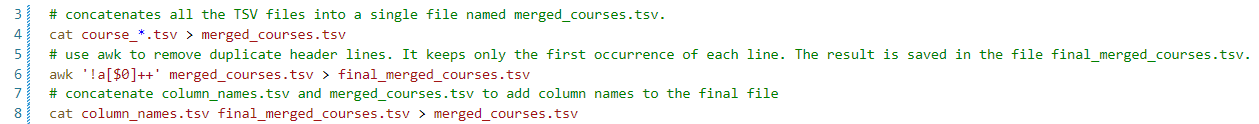

Now that you have your merged file named merged_courses.tsv, use Linux commands to answer the following questions:

* Which country offers the most Master's Degrees? Which city?
* How many colleges offer Part-Time education?
* Print the percentage of courses in Engineering (the word "Engineer" is contained in the course's name).

*Estratto di codice da CommandLine.sh*
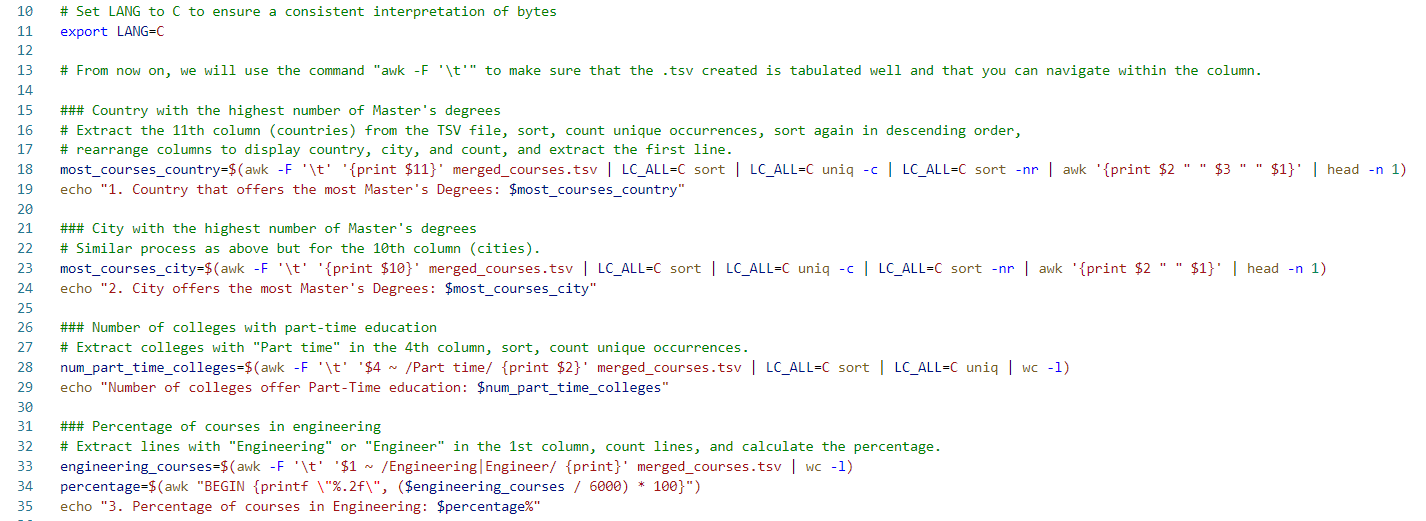

**Output**

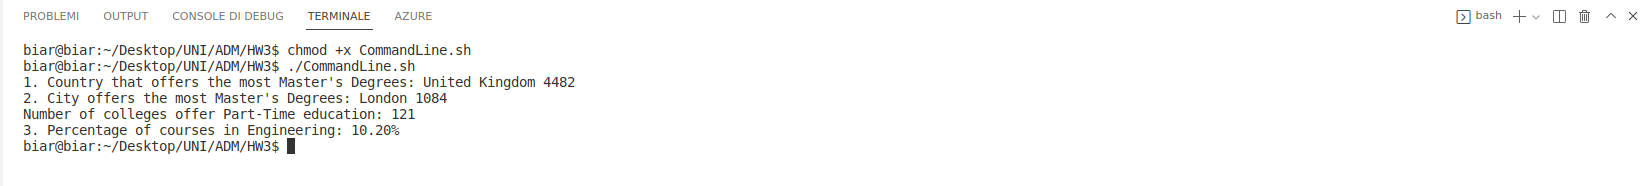

---
## [6] Algorithmic Question

Develop an algorithm to generate a report detailing the number of hours a worker (Leonardo) has worked each day for a specific number of days.

**Input**

The first line of input contains two integers:
- $d$ : the number of days Leonardo worked there;
- $sumHours$: the total number of hours he worked for the company.

Each of the following d lines contains two integer numbers:
- $minTime_{i}$: the minimum hours he can work on the $i_{th}$ day;
-$maxTime_{i}$: the maximum hours he can work on th $i_{th}$ day.

**Output**

- Output '**NO**' if a report cannot be generated.
- Output '**YES**' if a report can be generated, along with the number of hours Leonardo spent each day, indicated in the second line of the output.



In [ ]:
def report_hours ():
  d, sumHours = map(int, input().split())

  # Initialize empty lists to store minimum and maximum hours for each day
  minTime = []
  maxTime = []

  for i in range(d):
    min_i, max_i = map(int, input().split())

    # Add the minimum and maximum hours to their respective lists
    minTime.append(min_i)
    maxTime.append(max_i)

  # Initialize an array to store the hours worked each day
  dayHours=[0]*d

  # Check if it's possible to generate a report
  if (sumHours<d*min(minTime) or sumHours>d*max(maxTime)):
      print('NO') # output 'NO' if it cannot be generated
  else:
      # If it is possible to generate a report, distribute the minimum hours for each day
      count=sumHours # count the hours left
      for i in range(d):
        minHours=minTime[i]
        dayHours[i]=minHours
        count-=minHours

      # Now we are going to distribute the remaining hours within the allowed maximum hours
      for i in range(d):
        rangeHours=maxTime[i]-minTime[i] # number of hours that can be added for each days
        additionalHours=min(count,rangeHours)
        dayHours[i]+=additionalHours
        count-=additionalHours # count has to be zero at the end, meaning all hours are distributed
      print('YES')
      print(*dayHours)

Let's execute the two examples of input given by the homework.

**Example 1:**

In [ ]:
report_hours ()

2 5 
0 1 
3 5 
YES
1 4


**Example 2:**

In [ ]:
report_hours ()

1 1 
5 6 
NO


**Time complexity**

The code has been rewritten and annotated, incorporating the time complexity for each section of the code.

    def report_hours ():
    d, sumHours = map(int, input().split()) # O(1) it's a constant time operation

    minTime = []
    maxTime = []

    for i in range(d): # O(d) because it's a loop that runs d times
      min_i, max_i = map(int, input().split()) # O(1)
      minTime.append(min_i) # O(1)
      maxTime.append(max_i) # O(1)
      # all the operations inside the loop are a constant O(1)

    dayHours=[0]*d

    if (sumHours<d*min(minTime) or sumHours>d*max(maxTime)): # O(1)
      print('NO') # O(1)
    else:
      count=sumHours # O(1)  

      for i in range(d): # O(d) because it's a loop that runs d times
        minHours=minTime[i] # O(1)
        dayHours[i]=minHours # O(1)
        count-=minHours # O(1)
        # all the operations inside the loop are a constant O(1)
        
      
      for i in range(d): # O(d) because it's a loop that runs d times
        rangeHours=maxTime[i]-minTime[i]  # O(1)
        additionalHours=min(count,rangeHours) # O(1)
        dayHours[i]+=additionalHours # O(1)
        count-=additionalHours # O(1)
        # all the operations inside the loop are a constant O(1)

      print('YES') # O(1) it's a constant time operation
      print(*dayHours) # O(1) it's a constant time operation

In conclusion, the total time complexity of the report_hours() function is determined by summing the time complexities of all operations. The result is **O(d)**, which represents the worst-case scenario.

**Ask Chat GPT to check my code's time complexity**

After consulting Chat GPT about the time complexity of my code, the answer is as follows:

"In summary, because all the operations inside the function have a time complexity of O(1), the overall time complexity of the function is O(n), where n is the number of days"

This corresponds to the previously obtained result.

**Optimality of the code**

I believe that my code could be improved by replacing the for loops with list comprehensions, as they should be faster. After a detailed analysis of the code, it becomes evident that it was possible to avoid creating two for loops in the if statement and instead create a single loop to optimize the times.

In [ ]:
def report_hours ():
  d, sumHours = map(int, input().split())

  # Initialize empty lists to store minimum and maximum hours for each day
  minTime = []
  maxTime = []

  minTime, maxTime = zip(*[map(int, input().split()) for i in range(d)])

  # Initialize an array to store the hours worked each day
  dayHours=[0]*d

  # Check if it's possible to generate a report
  if (sumHours<d*min(minTime) or sumHours>d*max(maxTime)):
      print('NO') # output 'NO' if it cannot be generated
  else:
      # If it is possible to generate a report, distribute the minimum hours for each day
      count=sumHours # count the hours left
      for i in range(d):
        minHours=minTime[i]
        dayHours[i]=minHours
        count-=minHours

      # Now we are going to distribute the remaining hours within the allowed maximum hours
        rangeHours=maxTime[i]-minTime[i] # number of hours that can be added for each days
        additionalHours=min(count,rangeHours)
        dayHours[i]+=additionalHours
        count-=additionalHours # count has to be zero at the end, meaning all hours are distributed
      print('YES')
      print(*dayHours)